In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../../plotting.mplstyle')

In [2]:
import cymetric as cym
from cymetric import filters
from cymetric import graphs
from cymetric import timeseries
from cymetric import tools
import graphviz
import sqlite3

In [3]:
import importlib.util

# Specify the path relative to the current notebook's directory
dep_spec = importlib.util.spec_from_file_location('deployment', '../../scripts/deployment.py')
dep = importlib.util.module_from_spec(dep_spec)
dep_spec.loader.exec_module(dep)

tran_spec = importlib.util.spec_from_file_location('fuel_transactions', '../../scripts/fuel_transactions.py')
tran = importlib.util.module_from_spec(tran_spec)
tran_spec.loader.exec_module(tran)

waste_spec = importlib.util.spec_from_file_location('waste', '../../scripts/waste.py')
waste = importlib.util.module_from_spec(waste_spec)
waste_spec.loader.exec_module(waste)

products_spec = importlib.util.spec_from_file_location('products', '../../scripts/products.py')
products = importlib.util.module_from_spec(products_spec)
products_spec.loader.exec_module(products)

# Cymetric

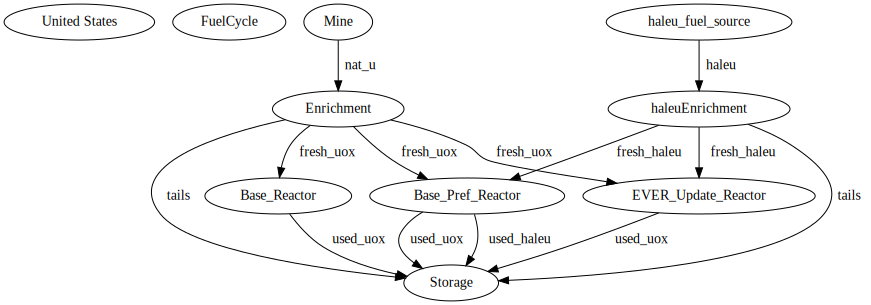

In [4]:
file = 'ever_update_test_out.sqlite'
conn = sqlite3.connect(file)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

db = cym.dbopen(file)
evaler = cym.Evaluator(db, write=False)
graphs.flow_graph(evaler, label='com')

In [5]:
reactor_list = ['Base_Reactor', 'Base_Pref_Reactor', 'EVER_Update_Reactor']
time = evaler.eval('TimeList')

Text(0, 0.5, 'Facilities [#]')

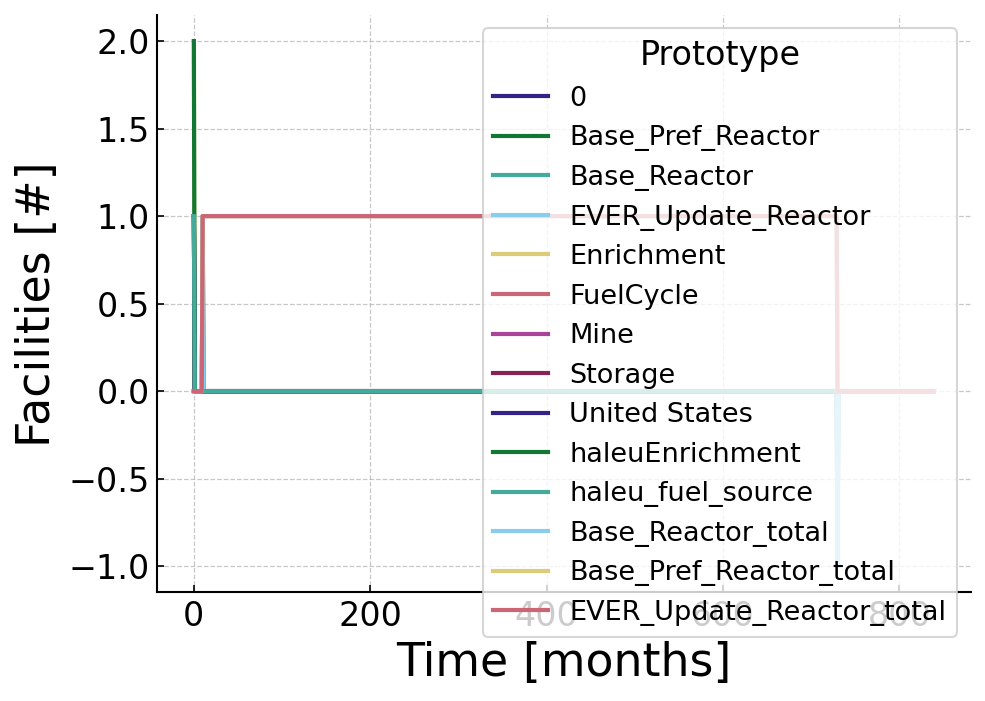

In [6]:
commission_by_prototype, commission_df = dep.comm_by_prototype(evaler, time)

decommission_by_prototype = dep.decom_by_prototype(evaler, commission_df, time)

deployment_by_prototype = dep.depl_by_prototype(commission_by_prototype, decommission_by_prototype, reactor_list)

deployment_by_prototype = dep.total_reactor(deployment_by_prototype, reactor_list)

deployment_by_prototype.plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Facilities [#]')

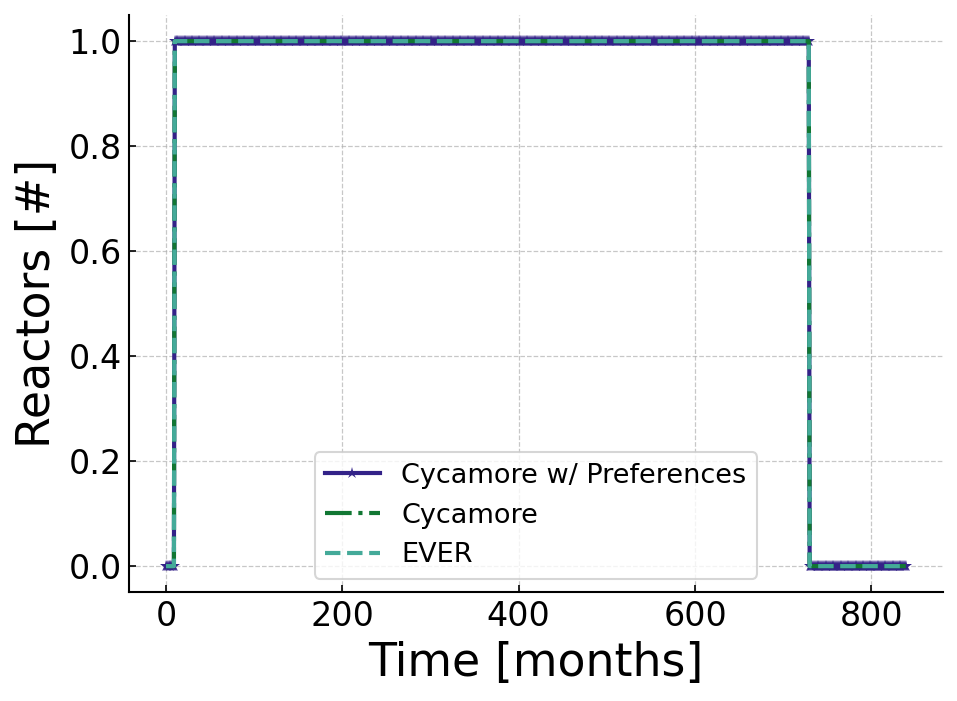

In [7]:
deployment_by_prototype[['Base_Pref_Reactor_total','Base_Reactor_total','EVER_Update_Reactor_total']].plot(use_index=True, style=['-*','-.','--'])
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

legend = plt.legend()
legend.get_texts()[0].set_text('Cycamore w/ Preferences')
legend.get_texts()[1].set_text('Cycamore')
legend.get_texts()[2].set_text('EVER')

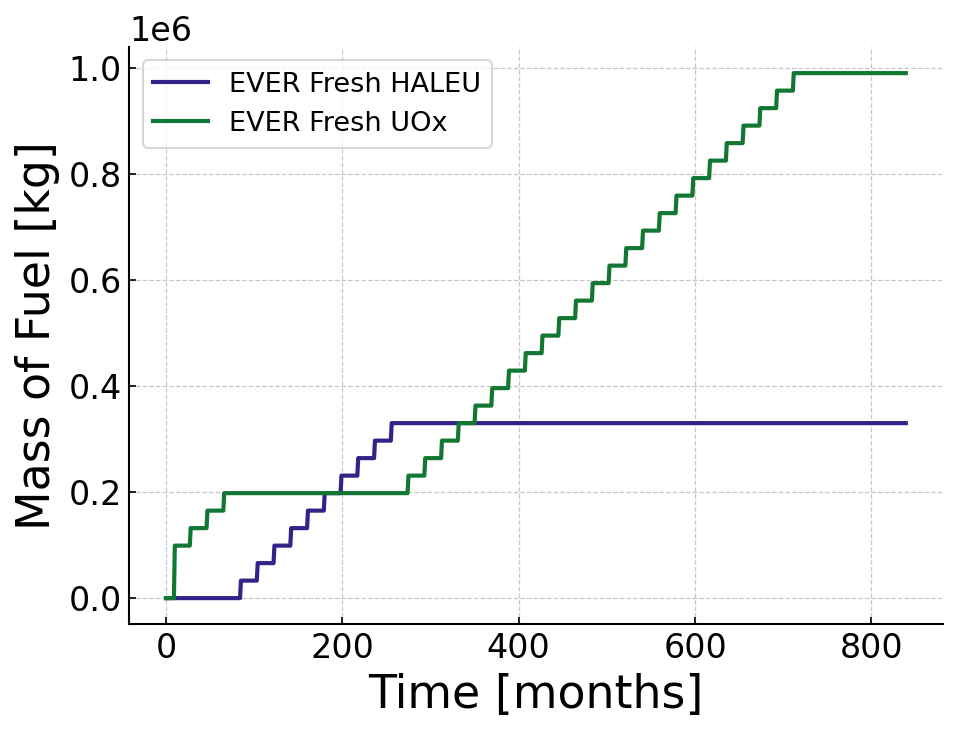

In [8]:
fuels = ['fresh_uox', 'fresh_haleu']
receivers = ['Base_Pref_Reactor','Base_Reactor','EVER_Update_Reactor']

ever_received = tran.fuel_received(evaler, fuels, receivers)

ever_received[['Time','fresh_haleu_EVER_Update_Reactor_total','fresh_uox_EVER_Update_Reactor_total']].plot(x='Time')

plt.xlabel('Time [months]')
plt.ylabel('Mass of Fuel [kg]')
legend = plt.legend()
legend.get_texts()[0].set_text('EVER Fresh HALEU')
legend.get_texts()[1].set_text('EVER Fresh UOx')

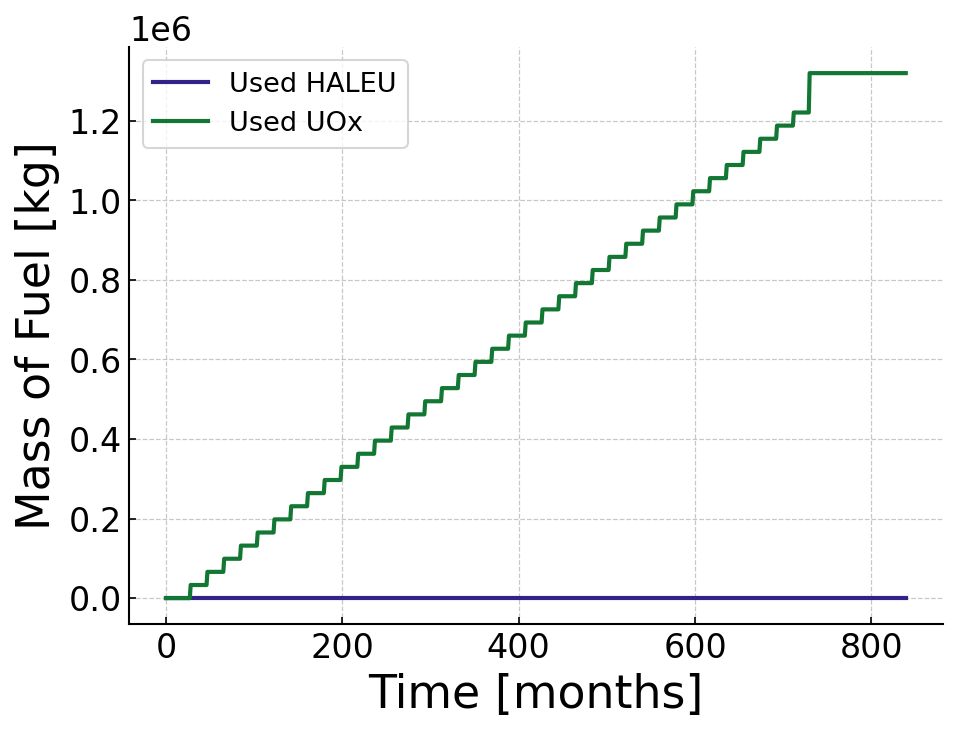

In [9]:
sent_fuels = ['used_uox', 'used_haleu']
ever_sent = tran.fuel_sent(evaler, sent_fuels, receivers)

ever_sent[['Time','used_haleu_EVER_Update_Reactor_total','used_uox_EVER_Update_Reactor_total']].plot(x='Time')

plt.xlabel('Time [months]')
plt.ylabel('Mass of Fuel [kg]')
legend = plt.legend()
legend.get_texts()[0].set_text('Used HALEU')
legend.get_texts()[1].set_text('Used UOx')

In [10]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

fuels = ['uox','haleu']

transactions = tran.used_fuel_transactions(transactions, fuels)
transactions = tran.fresh_fuel_transactions(transactions, fuels)
transactions = tran.total_used_fr_fuel(transactions, fuels)

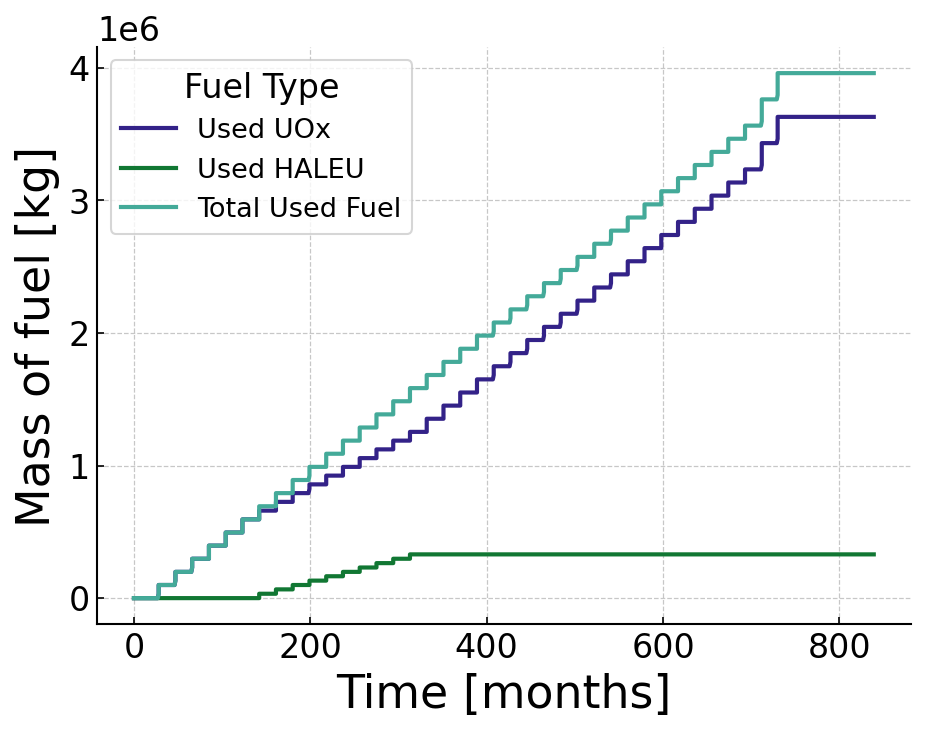

In [11]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'used_uox_total', 'used_haleu_total', 'total_used_fuel']].plot(x = 'Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of fuel [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Used UOx')
legend.get_texts()[1].set_text('Used HALEU')
legend.get_texts()[2].set_text('Total Used Fuel')
legend.set_title('Fuel Type')

Text(0, 0.5, 'Mass of U235 [kg]')

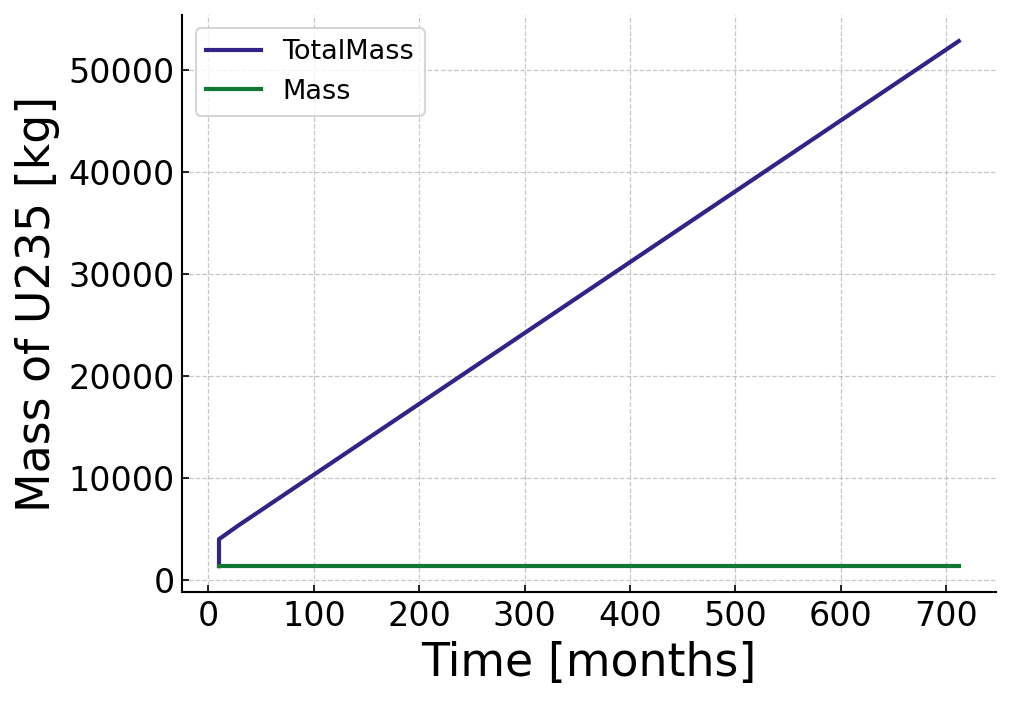

In [12]:
U235_mass = waste.transactions_nuc_built_in(evaler=evaler, receivers=['Base_Reactor'], commodities=['fresh_uox'], nucs=['92235'])

U235_mass['TotalMass'] = U235_mass['Mass'].cumsum()
U235_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

In [13]:
# waste classification isotopes
# u_isotopes = [
#     '922320000','922330000','922340000',
#     '922350000','922360000','922380000']

# np_isotopes = ['932370000']

# pu_isotopes = [
#     '942380000','942390000','942400000',
#     '942410000','942420000','942440000'] # 94236 and 94244 not included

# am_isotopes = ['952410000','952430000'] # 95242 not included

# cm_isotopes = [
#     '962440000','962430000','962460000',
#     '962450000','962480000','962470000',
#     '962350000','962370000'] # 96242 not included

all_isotopes = ['551370000','922350000','922380000','942390000']
commodities = ['used_uox','used_haleu','tails']
receivers = ['Storage']

isotope_db = waste.isotope_database(evaler=evaler,receivers=receivers, commodities=commodities, isotopes=all_isotopes)

/home/nsryan/Desktop/ornl/NEAR/EVER/update/../../scripts/waste.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '424.80234833659506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  isotope_df.loc[str(time_step),str(nucid)] = mass
/home/nsryan/Desktop/ornl/NEAR/EVER/update/../../scripts/waste.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '211976.37181996088' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  isotope_df.loc[str(time_step),str(nucid)] = mass
/home/nsryan/Desktop/ornl/NEAR/EVER/update/../../scripts/waste.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1333.198666801333' has dtype incompatible with int64, please explicitly cast to a co

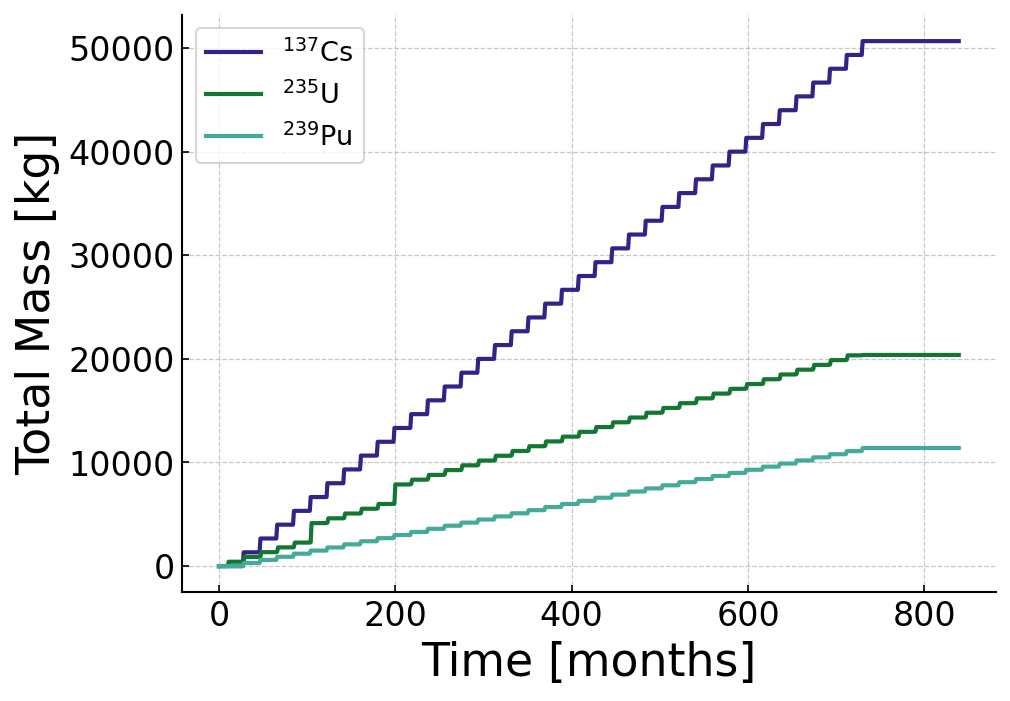

In [14]:
isotope_db[['Time','551370000_total','922350000_total','942390000_total']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Total Mass [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text(f'$^{{137}}$Cs')
legend.get_texts()[1].set_text(f'$^{{235}}$U')
legend.get_texts()[2].set_text(f'$^{{239}}$Pu')

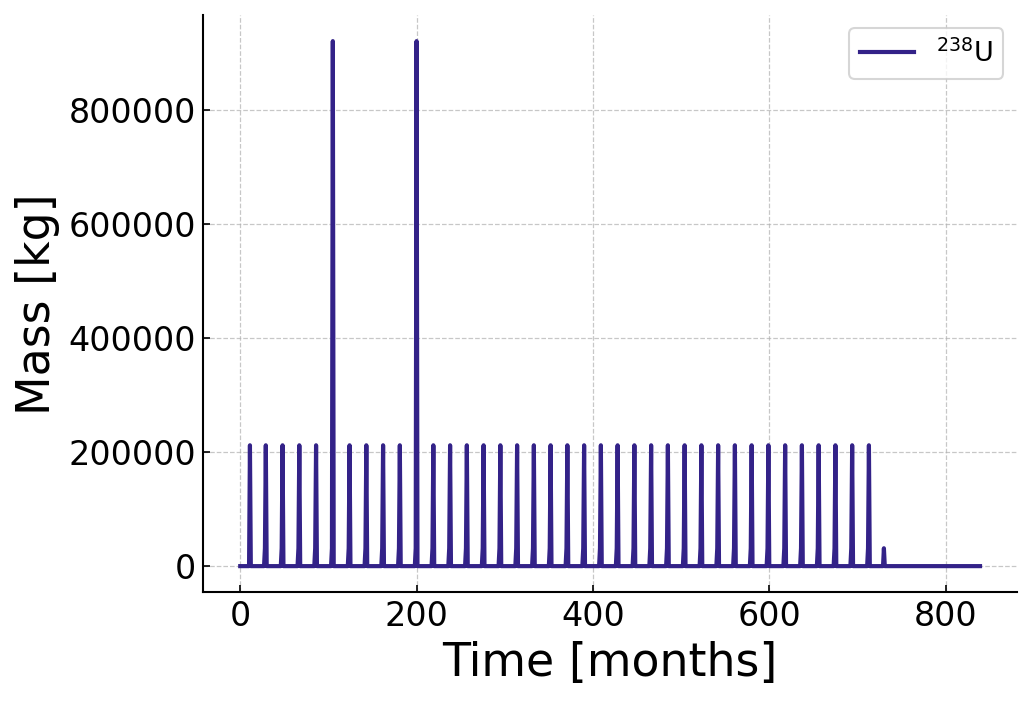

In [15]:
isotope_db[['Time','922380000']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text(f'$^{{238}}$U')

# Sqlite Analysis
In this section, I will use basic sqlite to generate plots of the remaining data.

In [16]:
# we will pull the DecomSchedule to see the ids and decommission date, to id
# the reactor
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 33, 730, 730)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 34, 730, 730)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 35, 730, 730)


In [17]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 25, 'Base_Reactor', 0, 10)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 25, 'Base_Pref_Reactor', 0, 10)
(b'\xc6\x7fk\xa8\xcbUK\x03\xa9F0bU\xf1\xbb\x83', 25, 'EVER_Update_Reactor', 0, 10)


## Energy Production

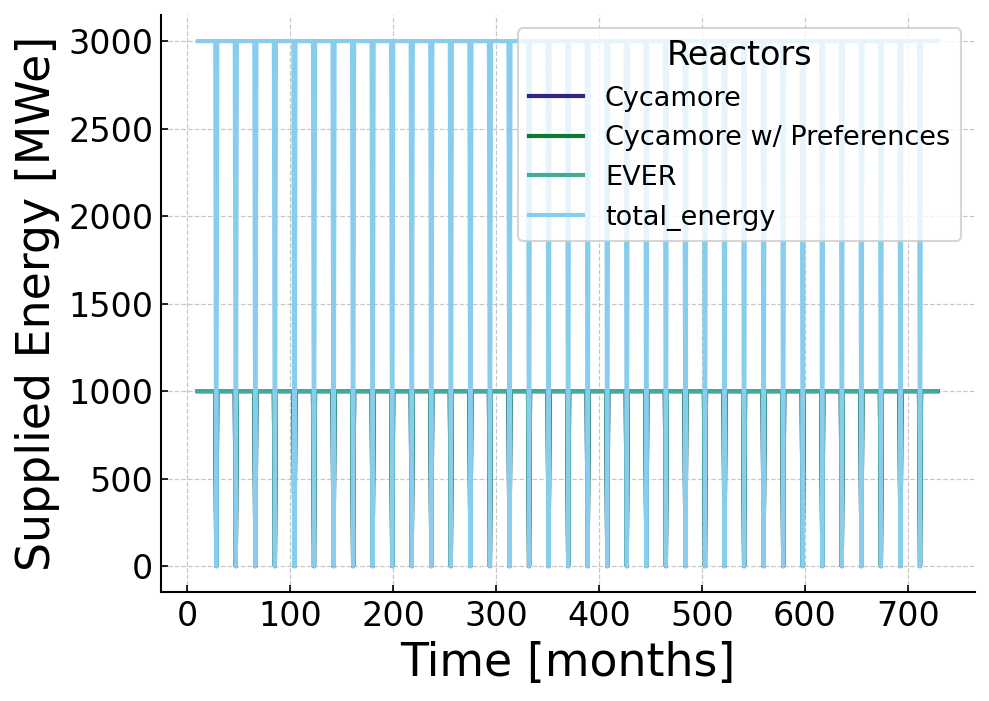

In [18]:
power_supply = products.energy_supply(cursor)

power_supply[['33','34','35','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Cycamore')
legend.get_texts()[1].set_text('Cycamore w/ Preferences')
legend.get_texts()[2].set_text('EVER')
legend.set_title('Reactors')

## SWU

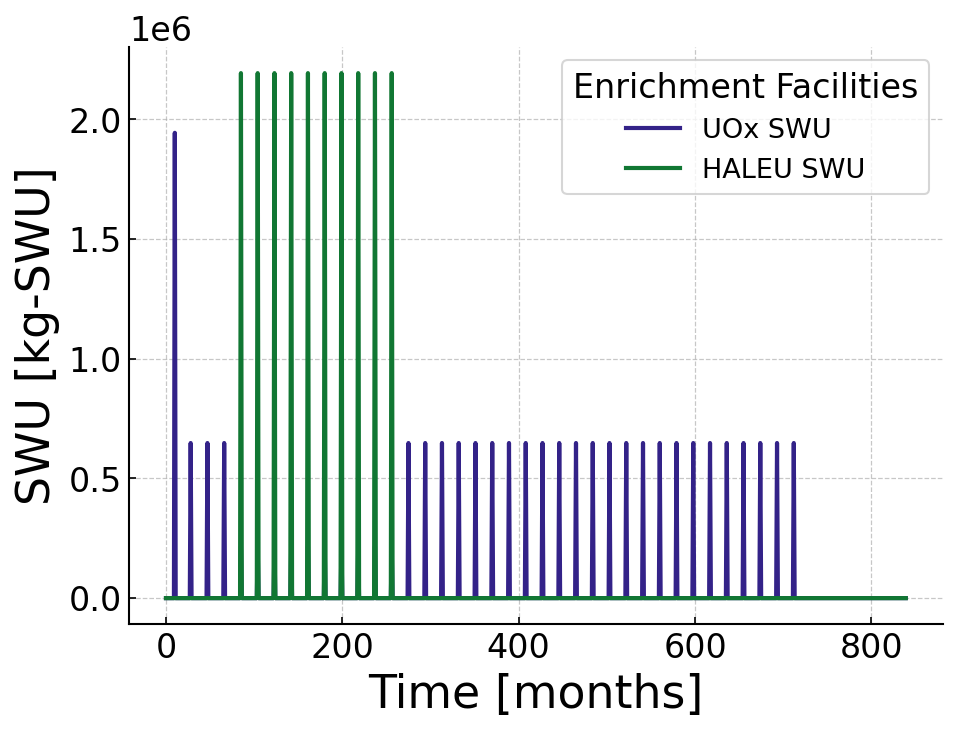

In [19]:
switch_swu_supply = products.swu_supply(cursor)

switch_swu_supply[['28', '30']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('UOx SWU')
legend.get_texts()[1].set_text('HALEU SWU')
# legend.get_texts()[2].set_text('Total SWU')
legend.set_title('Enrichment Facilities')